In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50


In [2]:
train_dir = '/content/drive/MyDrive/ct-kidney/dataset/train'
val_dir = '/content/drive/MyDrive/ct-kidney/dataset/val'
test_dir = '/content/drive/MyDrive/ct-kidney/dataset/test'

img_size = 224
batch_size = 32
epochs = 10


In [3]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

val_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)


Found 8714 images belonging to 4 classes.
Found 1865 images belonging to 4 classes.
Found 1873 images belonging to 4 classes.


In [4]:
num_classes = len(train_generator.class_indices)
total_images = len(train_generator.labels)

class_weights = {}
for i in range(num_classes):
    class_weights[i] = (1/num_classes) * (total_images / np.sum(train_generator.labels == i))


In [5]:
base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (img_size, img_size, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    class_weight=class_weights
)


Epoch 1/10
272/272 [==============================] - 2348s 8s/step - loss: 2.3546 - accuracy: 0.6649 - val_loss: 2.6894 - val_accuracy: 0.2996
Epoch 2/10
272/272 [==============================] - 222s 814ms/step - loss: 0.3234 - accuracy: 0.8803 - val_loss: 18.2656 - val_accuracy: 0.2996
Epoch 3/10
272/272 [==============================] - 218s 801ms/step - loss: 0.2290 - accuracy: 0.9214 - val_loss: 7.0845 - val_accuracy: 0.3077
Epoch 4/10
272/272 [==============================] - 222s 816ms/step - loss: 0.2336 - accuracy: 0.9225 - val_loss: 3.3910 - val_accuracy: 0.2236
Epoch 5/10
272/272 [==============================] - 219s 803ms/step - loss: 0.2023 - accuracy: 0.9301 - val_loss: 0.1227 - val_accuracy: 0.9488
Epoch 6/10
272/272 [==============================] - 216s 794ms/step - loss: 0.1981 - accuracy: 0.9392 - val_loss: 0.6393 - val_accuracy: 0.8190
Epoch 7/10
272/272 [==============================] - 222s 816ms/step - loss: 0.1212 - accuracy: 0.9607 - val_loss: 4.4782 - 

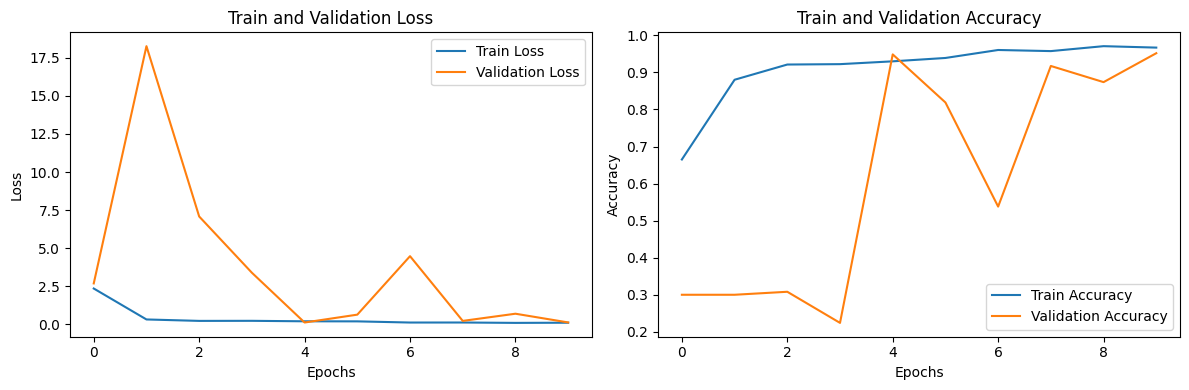

In [7]:
import matplotlib.pyplot as plt

# Courbes de perte (loss)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Courbes d'exactitude (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


58/58 [==============================] - 405s 7s/step - loss: 0.1287 - accuracy: 0.9504
Test Loss: 0.12872087955474854
Test Accuracy: 0.9504310488700867


59/59 [==============================] - 21s 335ms/step


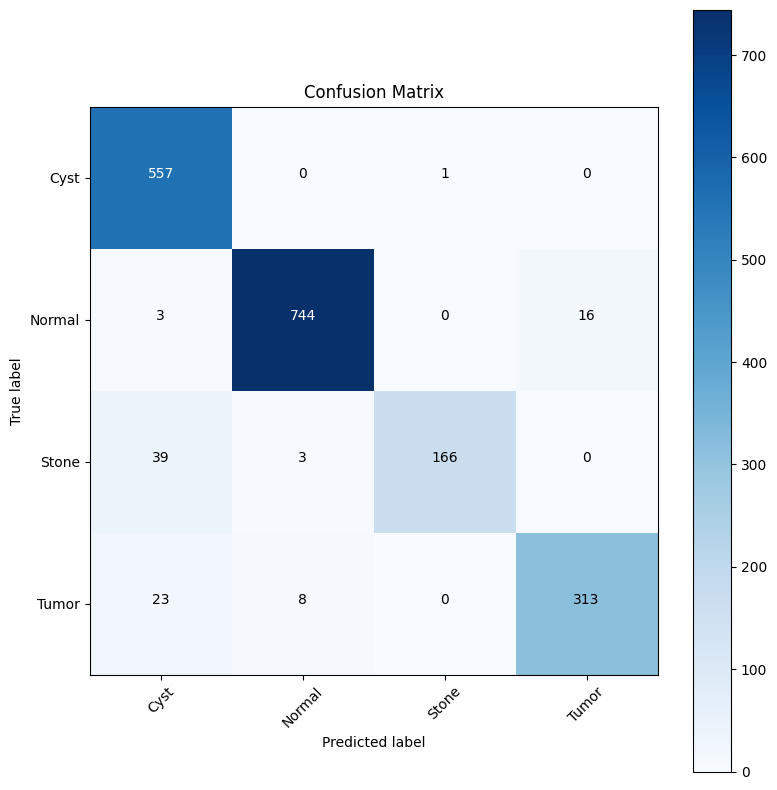

In [9]:
from sklearn.metrics import confusion_matrix
import itertools

# Prédiction sur l'ensemble de test
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Calcul de la matrice de confusion
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Affichage de la matrice de confusion
class_names = list(test_generator.class_indices.keys())
plot_confusion_matrix(confusion_mtx, classes=class_names)
plt.show()


In [10]:
model.save('/content/drive/MyDrive/ct-kidney/modele/kidney_classification_model(95% d\'evaluation sur donnée de teste).h5')
